In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
from PIL import Image
import json
import joblib
import cv2

In [2]:
preprocessed_path = r'D:\FUCK!!\Pattern\Project\notebooks\preprocessed_images'

In [3]:
# Create DataFrame to store image data
data = []

# Load images and store in DataFrame
for folder in ['train', 'val']:
    folder_path = os.path.join(preprocessed_path, folder)
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_dir): continue
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_file)
                # Read image in grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # Flatten the image
                img_flat = img.flatten()
                
                # Store in DataFrame
                data.append({
                    'image_path': img_path,
                    'class': class_name,
                    'folder': folder,
                    'image_data': img_flat
                })

In [4]:
# Create DataFrame
df = pd.DataFrame(data)

In [5]:
X = np.array(df['image_data'].tolist())
y = df['class'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Train RandomForest
rf = RandomForestClassifier(n_estimators=200,criterion='entropy', random_state=42,class_weight='balanced')
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
print(f"RandomForest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")

RandomForest Accuracy: 0.2857


In [26]:
from sklearn.metrics import classification_report
res = classification_report(y_test, rf_pred)
print(res)

                                  precision    recall  f1-score   support

         Achaemenid architecture       0.29      0.74      0.41       530
American Foursquare architecture       0.28      0.62      0.39       525
        American craftsman style       0.35      0.07      0.12       274
   Ancient Egyptian architecture       0.55      0.05      0.09       235
           Art Deco architecture       0.39      0.07      0.12       335
        Art Nouveau architecture       0.34      0.04      0.06       280
            Baroque architecture       0.27      0.12      0.17       355
            Bauhaus architecture       0.27      0.19      0.22       366
         Beaux-Arts architecture       0.23      0.15      0.18       356
          Byzantine architecture       0.32      0.24      0.27       335

                        accuracy                           0.29      3591
                       macro avg       0.33      0.23      0.20      3591
                    weighted avg    

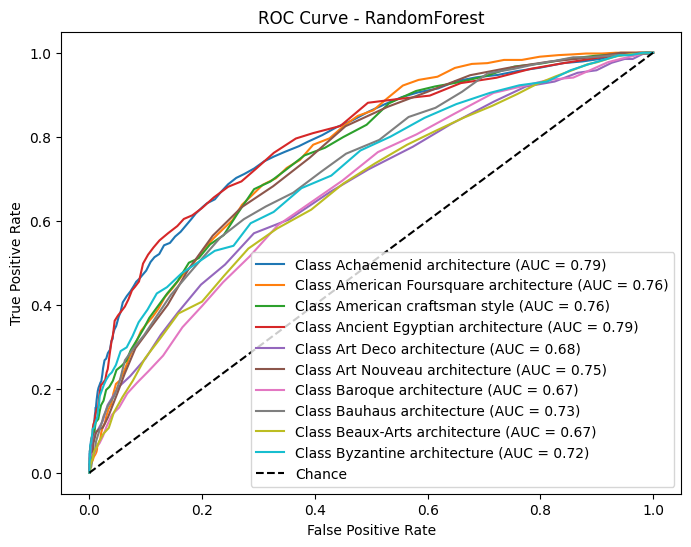

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output for multiclass ROC AUC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
rf_probs = rf.predict_proba(X_test_scaled)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_name in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], rf_probs[:, i])

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest')
plt.legend()
plt.show()